# WaveNet Image Models

**Author**: Chris Oswald

**Course**: CS676/ECE689 Advanced Topics in Deep Learning (Spring 2024)


## Question 2: WaveNet for Image Modeling

- Pick a WaveNet-typed model (e.g., WaveNet, ParallelWaveNet).
- Train the model for image modelling on MNIST.
- You can resize the MNIST images to 7 × 7 pixels to reduce computational complexity.

References:

- https://github.com/VincentStimper/normalizing-flows/blob/master/normflows
- https://github.com/kan-bayashi/ParallelWaveGAN/blob/master
- https://github.com/vincentherrmann/pytorch-wavenet/blob/master
- https://github.com/Zeta36/tensorflow-image-wavenet/tree/master
- https://www.youtube.com/watch?v=rT77lBfAZm4
- https://arxiv.org/pdf/1910.11480.pdf
- https://arxiv.org/pdf/1803.01271.pdf
- https://arxiv.org/pdf/1606.05328.pdf

## Set-up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
models_dir = "./drive/MyDrive/Colab Notebooks/Models"
os.makedirs(models_dir, exist_ok=True)

## Imports and Datasets

In [ ]:
# Import packages
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torch.distributions.multivariate_normal import MultivariateNormal

import normflows as nf

import copy

%matplotlib inline

In [ ]:
# Import resized MNIST data
ds_MNIST_7 = torchvision.datasets.MNIST(
    "MNIST/train",
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize(7),
        torchvision.transforms.ToTensor(),
    ])
)

100%|██████████| 9912422/9912422 [00:00<00:00, 35408415.13it/s]


Extracting MNIST/train/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/train/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 52258711.74it/s]


Extracting MNIST/train/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/train/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26116921.50it/s]


Extracting MNIST/train/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/train/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7011604.26it/s]


Extracting MNIST/train/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/train/MNIST/raw



In [ ]:
ds_MNIST_7

Dataset MNIST
    Number of datapoints: 60000
    Root location: MNIST/train
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=7, interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )

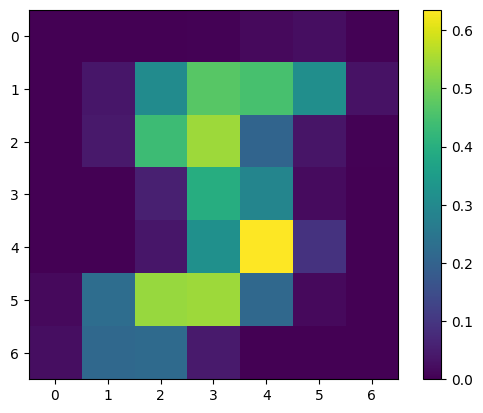

In [ ]:
# Confirm that dataset was loaded
first_image, first_label = ds_MNIST_7[0]
first_image = first_image.numpy().transpose(1, 2, 0)
image_plot = plt.imshow(first_image)
plt.colorbar(image_plot, orientation="vertical")

## Create Model

In [ ]:
# Define MAF teacher model architecture
torch.manual_seed(7777)
n_flows = 16

# Create flow layers
n_dim =  ds_MNIST_7[0][0].flatten().shape[0]
flows = []
for i in range(n_flows):
    flows.append(
        nf.flows.MaskedAffineAutoregressive(
            features=n_dim,
            hidden_features=32,
            use_batch_norm=True,
        )
    )

# Set base distribution
base_dist_t = nf.distributions.DiagGaussian(n_dim)

# Create model
model_t = nf.NormalizingFlow(q0=base_dist_t, flows=flows)
model_t = model_t.to(device).float()

In [ ]:
# Load state dict for MAF teacher model
load_model_name = "AutoRegNFmodel_epoch20"
load_model_path = os.path.join(models_dir, f"{load_model_name}.pt")

if torch.cuda.is_available():
    model_t.load_state_dict(torch.load(load_model_path))
else:
    model_t.load_state_dict(
        torch.load(load_model_path, map_location=torch.device("cpu"))
    )

In [ ]:
# Define Inverse Autoregressive Flow (IAF) student model
n_flows = 16

# Create flow layers
flows = []
for i in range(n_flows):
    flows.append(
        nf.flows.MaskedAffineAutoregressive(
            features=n_dim,
            hidden_features=32,
            use_batch_norm=True,
        )
    )

# Set base distribution
base_dist_s = nf.distributions.DiagGaussian(n_dim)

# Create model (uses same base distribution as teacher model, i.e., Gaussian)
model_s = nf.NormalizingFlow(q0=base_dist_s, flows=flows)
model_s = model_s.to(device).float()

# Specify optimizer
optimizer_s = torch.optim.Adam(model_s.parameters(), lr=1e-4, weight_decay=1e-6)

In [ ]:
# Train IAF student model for image generation using KL divergence loss
# (p(x) from MAF teacher model and q(x) from IAF student model)
load_model = True
load_model_name = "WaveNetmodel_epoch17"
load_model_path = os.path.join(models_dir, f"{load_model_name}.pt")

if load_model:
    if torch.cuda.is_available():
        model_s.load_state_dict(torch.load(load_model_path))
    else:
        model_s.load_state_dict(
            torch.load(load_model_path, map_location=torch.device("cpu"))
        )
else:
    epochs = 20
    batches_per_epoch = len(ds_MNIST_7) // batch_size
    lowest_avg_loss = None

    model_s.train()
    for t in range(epochs):
        batch_losses = []
        for batch_idx in range(batches_per_epoch):

            # Generate random noise as input to student model
            Z = base_dist_s.sample(batch_size).detach().to(device)

            # Generate sample images from student model
            X, log_det_s = model_s.forward_and_log_det(Z)

            # Calculate probability of samples according to student model (IAF)
            log_prob_s = base_dist_s.log_prob(Z) + log_det_s

            # Calculate probability of samples according to teacher model (MAF)
            _, log_det_t = model_t.inverse_and_log_det(X)
            log_prob_t = base_dist_t.log_prob(X) - log_det_t

            # Compute KL divergence
            loss = torch.mean(log_prob_s - log_prob_t)

            # Update model weights
            if ~(torch.isnan(loss) | torch.isinf(loss)):
                optimizer_s.zero_grad()
                loss.backward()
                optimizer_s.step()

                torch.nn.utils.clip_grad_norm_(model_s.parameters(), max_norm=1)

                # Record training batch loss
                loss_val = loss.item()
                batch_losses.append(loss_val)
            else:
                print(f'NaN/Inf loss for batch {batch_idx}')

        epoch_avg_loss = np.mean(batch_losses)
        print(f"Loss: {epoch_avg_loss:>7f} [Epoch {t+1}/{epochs}]")

        # Save model if improving
        epoch_avg_loss = np.mean(batch_losses)
        if (lowest_avg_loss is None) or (epoch_avg_loss < lowest_avg_loss):
            lowest_avg_loss = epoch_avg_loss
            model.save(os.path.join(models_dir, f'WaveNetmodel_epoch{t+1}.pt'))
            print(f'Saved model for epoch {t+1}')

Loss: -1474.013439 [Epoch 1/20]
Saved model for epoch 1
Loss: -1495.638616 [Epoch 2/20]
Saved model for epoch 2
Loss: -1512.022088 [Epoch 3/20]
Saved model for epoch 3
Loss: -1528.066470 [Epoch 4/20]
Saved model for epoch 4
Loss: -1547.976271 [Epoch 5/20]
Saved model for epoch 5
Loss: -1566.857533 [Epoch 6/20]
Saved model for epoch 6
Loss: -1600.571494 [Epoch 7/20]
Saved model for epoch 7
Loss: -1646.542333 [Epoch 8/20]
Saved model for epoch 8
Loss: -1686.754787 [Epoch 9/20]
Saved model for epoch 9
Loss: -1736.303904 [Epoch 10/20]
Saved model for epoch 10
Loss: -1770.750298 [Epoch 11/20]
Saved model for epoch 11
Loss: -1793.071774 [Epoch 12/20]
Saved model for epoch 12
Loss: -1818.896774 [Epoch 13/20]
Saved model for epoch 13
Loss: -1847.959968 [Epoch 14/20]
Saved model for epoch 14
Loss: -1891.282196 [Epoch 15/20]
Saved model for epoch 15
Loss: -1932.201363 [Epoch 16/20]
Saved model for epoch 16


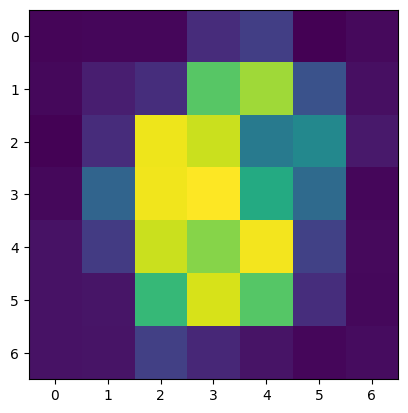

In [ ]:
# Sample from student model
z, _ = model_s.sample(2)
z = z.view(2, 7, 7).to("cpu").detach().numpy()
plt.imshow(z[0])

## *Archived Attempts [For Reference]*

### Using `ParallelWaveGAN` library

In [ ]:
# # Install library
# # Provided under MIT License
# # Copyright (c) 2020 Tomoki Hayashi <hayashi.tomoki@g.sp.m.is.nagoya-u.ac.jp>
# !pip install parallel-wavegan

In [ ]:
# # Import WaveNet Generator class
# from parallel_wavegan.models import ParallelWaveGANGenerator

In [ ]:
# # Create model
# batch_size = 64
# lr = 1e-4
# in_channels = ds_MNIST_7[0][0].shape[0]

# model = ParallelWaveGANGenerator(
#     in_channels=in_channels,
#     out_channels=1,
#     kernel_size=2,
#     use_causal_conv=True,
# )

# optimizer = optim.Adam(model.parameters(), lr=lr)

In [ ]:
# # Load/train model
# load_model = False
# load_model_name = ""
# load_model_path = os.path.join(models_dir, f"{load_model_name}.pt")

# if load_model:
#     if torch.cuda.is_available():
#         model.load_state_dict(torch.load(load_model_path))
#     else:
#         model.load_state_dict(
#             torch.load(load_model_path, map_location=torch.device("cpu"))
#         )
# else:
#     batch_size = 256
#     epochs = 4

#     dl = DataLoader(ds_MNIST_7, batch_size=batch_size, shuffle=True, drop_last=True)
#     size = len(dl.dataset)

#     lowest_avg_loss = None

#     model.train()
#     for t in range(epochs):
#         batch_losses = []
#         for batch, (X, _) in enumerate(dl):

#             # Unroll image data to 1D
#             X = X.view(batch_size, 1, -1)

#             # # Sequence of full length (for testing)
#             # output = model(X, c=None)
#             # loss = F.kl_div(output.flatten(), X.flatten(), reduction="batchmean")

#             # if ~(torch.isnan(loss) | torch.isinf(loss)):
#             #     optimizer.zero_grad()
#             #     loss.backward()
#             #     optimizer.step()

#             #     # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

#             #     # Record training batch loss
#             #     loss_val = loss.item()
#             #     batch_losses.append(loss_val)


#             # Create 7-pixel sequences of 1D data (each row is 7 pixels)
#             for i in range(7, X.shape[-1], 7):
#                 x_seq = X[:, :, 0:i].to(device) # Create sequence of input values
#                 target = X[:, :, i:i+7].to(device) # Identify next row of pixels to predict
#                 # Pad on the left
#                 x_seq_padded = F.pad(x_seq, pad=(X.shape[-1]-i, 0), value=0)

#                 output = model(x_seq_padded, c=None)[:, :, -8:-1] # Extract predicted vals
#                 loss = F.mse_loss(output.flatten(), target.flatten())

#                 if ~(torch.isnan(loss) | torch.isinf(loss)):
#                     optimizer.zero_grad()
#                     loss.backward()
#                     optimizer.step()

#                     # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

#                     # Record training batch loss
#                     loss_val = loss.item()
#                     batch_losses.append(loss_val)

#         epoch_avg_loss = np.mean(batch_losses)
#         print(f"Loss: {epoch_avg_loss:>7f} [Epoch {t+1}/{epochs}]")

#         # Save model if improving
#         if (lowest_avg_loss is None) or (epoch_avg_loss < lowest_avg_loss):
#             lowest_avg_loss = epoch_avg_loss
#             torch.save(
#                 model.state_dict(),
#                 os.path.join(models_dir, f'WaveNetmodel_epoch{t+1}.pt')
#             )
#             print(f'Saved model for epoch {t+1}')

### Using `pytorch-wavenet` library

In [ ]:
# # Clone pytorch-wavenet library and import WaveNetModel
# # Source: https://github.com/vincentherrmann/pytorch-wavenet
# # MIT License, Copyright (c) 2017 Vincent Herrmann

# # Note that the following clone is a forked and modified version due to
# # runtime errors in the original repo related to pytorch autograd deprecation
# !git clone https://github.com/cdoswald/pytorch-wavenet.git

# import os
# os.chdir("pytorch-wavenet/")

# from wavenet_model import WaveNetModel

# model = WaveNetModel(
#     layers=10,
#     classes=1,
#     output_length=1,
#     kernel_size=2,
#     skip_channels=1024,
# )
# model